
## Agglomerative Hierarchical Clustering

#### Amena Alelg


### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


## Agglomerative Hierarchical Clustering Overview

Agglomerative Hierarchical Clustering (AHC) is a bottom-up clustering method. It starts by treating each data point as its own cluster and iteratively merges the closest pairs of clusters until a stopping criterion is met (e.g., number of clusters).
###  Steps of Agglomerative Hierarchical Clustering

1. **Compute the distance matrix**:  
   Measure the pairwise distance between all data points using a chosen metric (e.g., Euclidean).

2. **Initialize each point as its own cluster**:  
   Each data point starts in a separate cluster.

3. **Choose a linkage method to define cluster distance**:  
   The linkage method controls how distances between clusters are computed:
   - Single linkage: uses the minimum distance between points in the two clusters
   - Complete linkage: uses the maximum distance between points in the two clusters
   - Average linkage: uses the average of all pairwise distances between points in the two clusters
   - Ward’s linkage: merges clusters that result in the smallest increase in within-cluster variance

4. **Iteratively merge the closest clusters**:  
   Using the chosen linkage method, merge the pair of clusters that are closest together.

5. **Update the distance matrix**:  
   After each merge, recompute distances between the new cluster and all remaining clusters.

6. **Build a dendrogram**:  
   A tree-like diagram that shows the order and distance at which clusters were merged.

7. **Estimate the number of clusters**:  
   - Visually: Cut the dendrogram at a specific height to form distinct groups.
   - Statistically: Use evaluation metrics to validate the chosen number of clusters.

8. **Evaluate clustering quality using internal metrics**:
   - **Silhouette Score** (higher is better):  
     Measures how well each point fits within its assigned cluster compared to other clusters.  
     Values close to +1 indicate that the point is well-matched to its cluster and far from others.  
     Values near 0 indicate overlapping clusters, and negative values suggest misclassification.

   - **Davies-Bouldin Index** (lower is better):  
     Evaluates the average "similarity" between each cluster and the cluster most similar to it.  
     A lower score means clusters are compact and well-separated.  
     Higher values indicate that clusters are not well defined or are overlapping.

9. **Assign final cluster labels**:  
   Based on the selected number of clusters, assign each point to its corresponding cluster.


### Advantages
- No need to pre-specify the number of clusters (can be decided later using dendrogram).
- Works well with small to medium datasets.
- Produces a hierarchy of clusters useful for exploration.
- Easy to interpret using dendrograms.

### Limitations
- Computationally expensive for large datasets (O(n²) or higher).
- Sensitive to noise and outliers.
- Once a merge is done, it cannot be undone (greedy approach).


### Executive Summary

The primary objective of this work is to determine an objective approach for selecting the optimal number of clusters in agglomerative hierarchical clustering, while validating its performance against other clustering techniques and assessing its sensitivity to outliers and linkage methods.

This was accomplished by first using dendrogram visualizations to identify potential cluster counts, followed by validation through internal evaluation metrics — specifically the Silhouette Score and Davies-Bouldin Index.

Agglomerative hierarchical clustering was compared to K-Means and DBSCAN. Among the linkage methods, Ward’s linkage produced the most stable and interpretable clusters, while Single linkage performed poorly.

Based on the analysis, it is recommended to:

* Use Silhouette Score and Davies-Bouldin Index to validate the number of clusters
* Default to Ward’s linkage for most applications
* Apply preprocessing for outlier removal when using agglomerative clustering

### Import Packages

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from ipywidgets import widgets, interact, FloatSlider, IntSlider, Dropdown
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Load Data

The following workflow applies the .csv file 'Mall_Customers.csv'. This data set is created only for the learning purposes. The dataset is publically available  [https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data]

We will work with the following customer attributes:

**Age** - Customer's age in years

**Annual Income (k$)** - Yearly earnings in thousands of US dollars

**Spending Score (1-100)** - Mall's proprietary metric of customer spending behavior (normalized)

**Gender** - Categorical demographic identifier (Male/Female)


In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/aalelg/Data/main/Mall_Customers.csv')
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


**Data Standarization**

Standardization rescales features to comparable ranges, preventing variables with larger numerical values from dominating cluster assignments. This is  critical requirement for distance-based clustering methods.

In [3]:
# Select features for clustering
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)


# 1. Agglomerative Hierarchical Clustering

**Interactive Dendrogram Exploration**


The dendrogram shows how clusters are merged step by step using Ward’s method. The height of each merge reflects the dissimilarity between the clusters.

To choose the optimal number of clusters:
- Look for the largest vertical gap between merge steps.
- Draw a horizontal cutoff just below that gap.
- The number of vertical lines the cutoff crosses equals the number of clusters.

For this dataset, the largest gap creates 5 clusters.


In [4]:
# Calculate the linkage matrix using Ward's method
Z = linkage(scaled_features, method='ward')
def plot_interactive_dendrogram(cutoff):
    plt.figure(figsize=(12, 6))
    dendrogram(Z, truncate_mode='lastp', p=20, color_threshold=cutoff)
    plt.title(f'Hierarchical Clustering Dendrogram (Cutoff at {cutoff:.1f})')
    plt.xlabel('Customer Index')
    plt.ylabel('Distance')
    plt.axhline(y=cutoff, color='r', linestyle='--')
    plt.show()

# Create an interactive widget to determine number of clusters
interact(plot_interactive_dendrogram,
         cutoff=FloatSlider(min=0, max=20, step=1, value=5, description='Cutoff Distance'))

interactive(children=(FloatSlider(value=5.0, description='Cutoff Distance', max=20.0, step=1.0), Output()), _d…

<function __main__.plot_interactive_dendrogram(cutoff)>

**Silhouette Analysis for Optimal Cluster Count**

This analysis uses two methods to determine the best number of groups. The Silhouette Score (0-1) checks how well customers fit within their groups, where higher numbers mean better grouping. The Davies-Bouldin Index (0+) measures how distinct the groups are from each other, where lower numbers are better. By showing both measures together, we can spot where they agree - typically where the Silhouette Score is highest and the Davies-Bouldin Index is lowest.

###Clustering Evaluation Metrics

#### 1. **Silhouette Score**
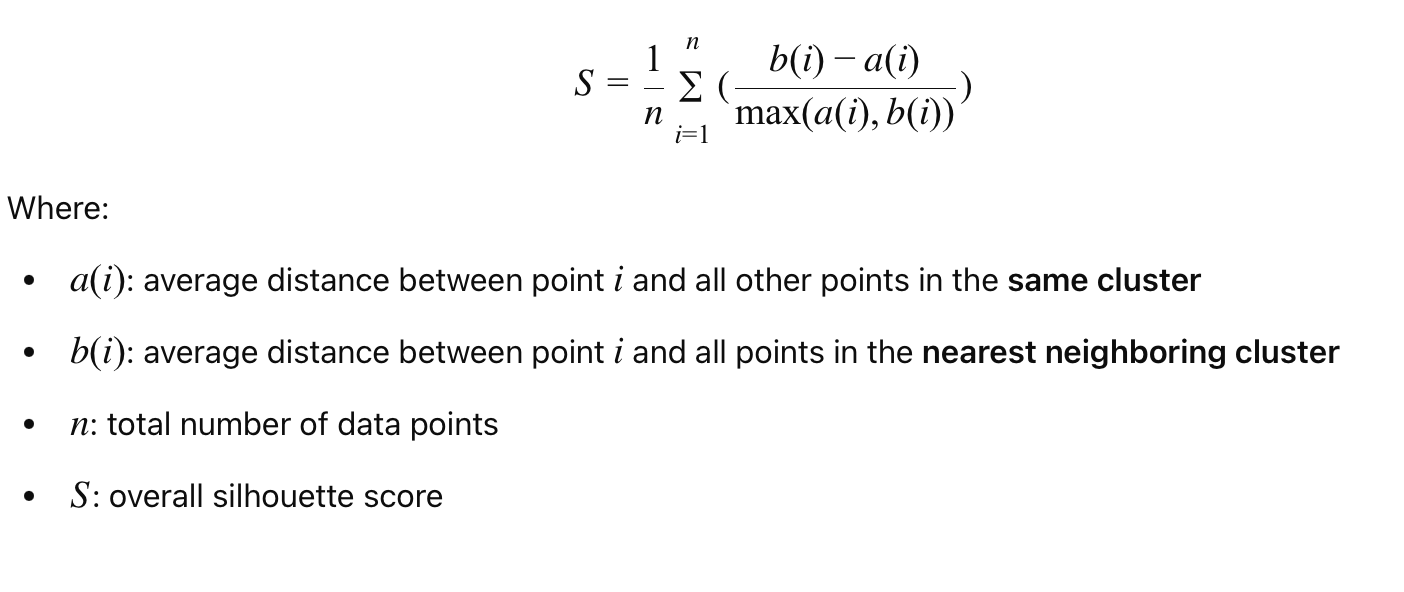

#### 2. **Davies-Bouldin Index**
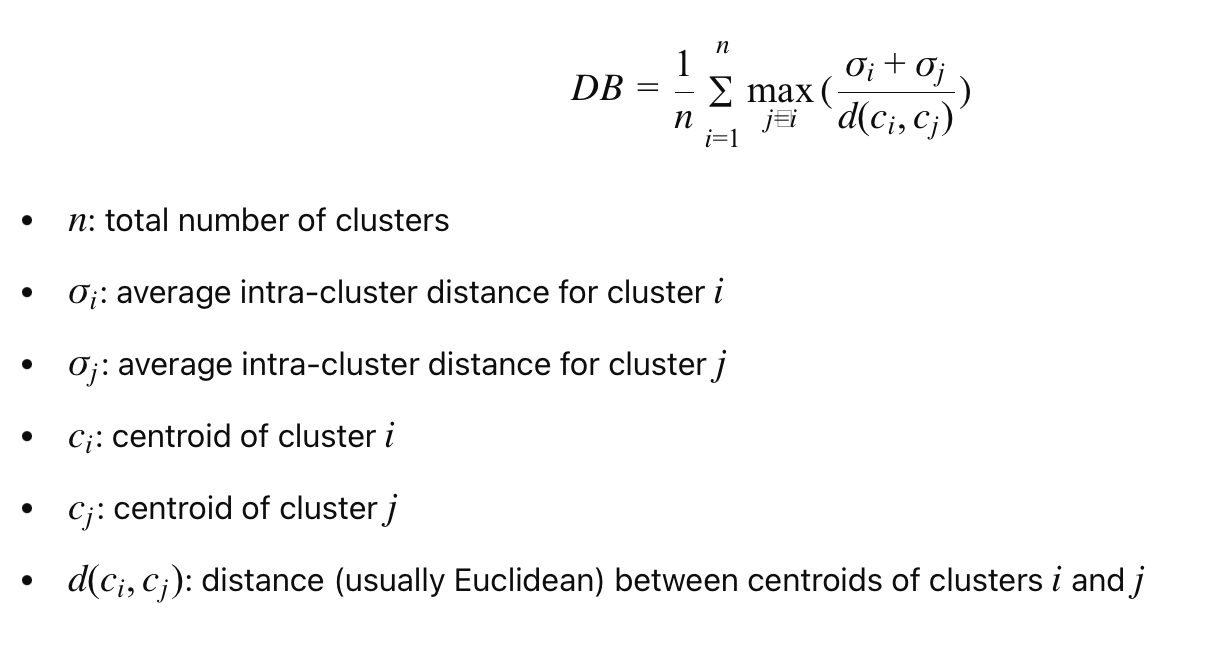



For this dataset, the dendrogram suggests 5 clusters, based on the largest gap.
This choice was confirmed by both evaluation metrics — Silhouette Score and Davies-Bouldin Index — which also identified 5 as the optimal number.


In [5]:

# Calculate silhouette scores and Davies-Bouldin Index
range_n_clusters = range(2, 8)
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='euclidean',
        linkage='ward'
    )
    cluster_labels = clusterer.fit_predict(scaled_features)

    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_features, cluster_labels))

# Create comparison plot
fig = make_subplots(rows=1, cols=2, subplot_titles=('Silhouette Score (Higher=Better)',
                                                   'Davies-Bouldin Index (Lower=Better)'))

# Add Silhouette scores
fig.add_trace(
    go.Scatter(x=list(range_n_clusters), y=silhouette_scores,
               mode='lines+markers', name='Silhouette'),
    row=1, col=1
)

# Add Davies-Bouldin scores
fig.add_trace(
    go.Scatter(x=list(range_n_clusters), y=davies_bouldin_scores,
               mode='lines+markers', name='DBI', line=dict(color='red')),
    row=1, col=2
)

# Formatting
fig.update_layout(
    title_text='Optimal Cluster Selection',
    showlegend=False,
    xaxis1=dict(tickmode='linear', tick0=2, dtick=1),
    yaxis1=dict(range=[0, 1]),
    xaxis2=dict(tickmode='linear', tick0=2, dtick=1)
)
fig.update_yaxes(title_text="Score", row=1, col=1)
fig.update_yaxes(title_text="Score", row=1, col=2)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)

fig.show()

**Perform Clustering with the Selected Number of Clusters**

This code block creates an interactive plot that allows the usesr to dynamically change the number of clusters used in Agglomerative Hierarchical Clustering and immediately see the clustering results and evaluation metrics.

In [6]:
from ipywidgets import interact, IntSlider

def plot_clusters(n_clusters=5):
    plt.figure(figsize=(10, 6))

    # Perform clustering with selected number of clusters
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    clusters = hc.fit_predict(scaled_features)

    # Visualization using standardized features
    for cluster in range(n_clusters):
        cluster_mask = (clusters == cluster)
        plt.scatter(scaled_df.iloc[cluster_mask, 0],
                   scaled_df.iloc[cluster_mask, 1],
                   label=f'Cluster {cluster}',
                   alpha=0.7)

    plt.title(f'Customer Segmentation (k={n_clusters})')
    plt.xlabel('Standardized Annual Income (z-score)')
    plt.ylabel('Standardized Spending Score (z-score)')
    plt.legend()
    plt.grid(alpha=0.3)

    # Calculate and display metrics
    metrics_text = (
        f"Clusters: {n_clusters}\n"
        f"Silhouette: {silhouette_score(scaled_features, clusters):.3f}\n"
        f"DB Index: {davies_bouldin_score(scaled_features, clusters):.3f}"
    )
    plt.text(0.05, 0.95, metrics_text,
             transform=plt.gca().transAxes,
             ha='left', va='top',
             fontsize=12, family='monospace',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(
    plot_clusters,
    n_clusters=IntSlider(value=5, min=2, max=10, step=1,
                        description='Number of Clusters:',
                        style={'description_width': 'initial'})
)

interactive(children=(IntSlider(value=5, description='Number of Clusters:', max=10, min=2, style=SliderStyle(d…

<function __main__.plot_clusters(n_clusters=5)>

# 2. Comparative Analysis

**K-Means Clustering Implementation**


This code creates an interactive visualization for exploring K-Means clustering. A slider allows the user to change the number of clusters and observe the clustering and how quality metrics respond. The widget helps the user to visually assess and compare different values of K, and identify the most meaningful number of clusters for K-Means.


In [7]:
def interactive_kmeans(n_clusters=5):
    # Clear previous plot
    plt.close('all')

    # Perform K-Means clustering on standardized features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    # Create figure
    plt.figure(figsize=(12, 5))

    # Left plot: Clusters using standardized features
    plt.subplot(1, 2, 1)
    for cluster in np.unique(clusters):
        mask = (clusters == cluster)
        plt.scatter(scaled_features[mask, 0],
                   scaled_features[mask, 1],
                   label=f'Cluster {cluster}', alpha=0.7)

    plt.title(f'K-Means Clustering (Standardized)\n(k={n_clusters})')
    plt.xlabel('Standardized Annual Income (z-score)')
    plt.ylabel('Standardized Spending Score (z-score)')
    plt.legend()
    plt.grid(alpha=0.2)

    # Right plot: Metrics
    plt.subplot(1, 2, 2)
    metrics_text = (
        f"Silhouette: {silhouette_score(scaled_features, clusters):.3f}\n"
        f"Davies-Bouldin: {davies_bouldin_score(scaled_features, clusters):.3f}\n"
        f"Clusters: {n_clusters}"
    )
    plt.text(0.5, 0.5, metrics_text, ha='center', va='center',
             fontsize=12, family='monospace')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(
    interactive_kmeans,
    n_clusters=IntSlider(
        value=5,
        min=2,
        max=10,
        step=1,
        description='Number of Clusters:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
)

interactive(children=(IntSlider(value=5, continuous_update=False, description='Number of Clusters:', max=10, m…

<function __main__.interactive_kmeans(n_clusters=5)>

**DBSCAN Clustering**

This density-based clustering code identifies customer segments by grouping nearby points (within ε distance) in standardized feature space, while flagging outliers as noise. The interactive controls allow tuning of two key parameters: neighborhood radius (ε) and minimum cluster size. The visualization highlights both discovered patterns and outliers, with automatic validation metrics for quality assessment.

In [8]:
def interactive_dbscan(eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(scaled_features)

    # Create figure
    plt.figure(figsize=(12, 5))

    # Left plot: Clusters
    plt.subplot(1, 2, 1)
    for cluster in np.unique(clusters):
        mask = (clusters == cluster)
        if cluster == -1:  # Noise
            plt.scatter(scaled_features[mask, 0],
                       scaled_features[mask, 1],
                       c='black', marker='x', label='Noise', alpha=0.7)
        else:
            plt.scatter(scaled_features[mask, 0],
                       scaled_features[mask, 1],
                       label=f'Cluster {cluster}', alpha=0.7)

    plt.title(f'DBSCAN (Standardized)\nε={eps}, min_samples={min_samples}')
    plt.xlabel('Standardized Annual Income (z-score)')
    plt.ylabel('Standardized Spending Score (z-score)')
    plt.legend()
    plt.grid(alpha=0.2)

    # Right plot: Metrics
    plt.subplot(1, 2, 2)
    n_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)

    if n_clusters > 1:
        metrics_text = (
            f"Clusters: {n_clusters}\n"
            f"Silhouette: {silhouette_score(scaled_features, clusters):.3f}\n"
            f"Davies-Bouldin: {davies_bouldin_score(scaled_features, clusters):.3f}"
        )
    else:
        metrics_text = "No valid clusters\n(only noise)"

    plt.text(0.5, 0.5, metrics_text, ha='center', va='center',
             fontsize=12, family='monospace',
             bbox=dict(facecolor='white', alpha=0.8))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(
    interactive_dbscan,
    eps=FloatSlider(value=0.5, min=0.1, max=1.5, step=0.05,
                   description='ε (eps):',
                   style={'description_width': 'initial'}),
    min_samples=IntSlider(value=5, min=2, max=20,
                         description='Min Samples:',
                         style={'description_width': 'initial'})
)

interactive(children=(FloatSlider(value=0.5, description='ε (eps):', max=1.5, min=0.1, step=0.05, style=Slider…

<function __main__.interactive_dbscan(eps=0.5, min_samples=5)>

**Comparative Analysis**

This block provides an interactive tool for comparing Agglomerative, K-Means, and DBSCAN clustering side by side. After inspecting each method individually and selecting optimal hyperparameters in earlier sections, this tool allows the user to manually input those parameters and add the results to a comparison table. The table displays the number of clusters, noise points (for DBSCAN), and evaluation metrics (Silhouette Score and Davies-Bouldin Index) for each method. This makes it easy to compare clustering performance across all techniques in a unified view.


In [9]:
def create_clustering_comparison(df, scaled_features):
    # Widgets for manual parameter input
    method_dropdown = widgets.Dropdown(
        options=['Agglomerative', 'K-Means', 'DBSCAN'],
        description='Method:',
        layout={'width': '300px'}
    )

    n_clusters_input = widgets.IntText(
        value=5,
        description='n_clusters:',
        disabled=False,
        layout={'width': '200px'}
    )

    eps_input = widgets.FloatText(
        value=0.5,
        description='eps:',
        disabled=False,
        layout={'width': '200px'}
    )

    min_samples_input = widgets.IntText(
        value=5,
        description='min_samples:',
        disabled=False,
        layout={'width': '200px'}
    )

    add_button = widgets.Button(
        description='Add to Comparison',
        button_style='success',
        layout={'width': '200px'}
    )

    # Show/hide relevant parameters based on method selection
    def update_ui(change):
        method = change['new']
        if method == 'Agglomerative' or method == 'K-Means':
            eps_input.layout.visibility = 'hidden'
            min_samples_input.layout.visibility = 'hidden'
            n_clusters_input.layout.visibility = 'visible'
        else:  # DBSCAN
            eps_input.layout.visibility = 'visible'
            min_samples_input.layout.visibility = 'visible'
            n_clusters_input.layout.visibility = 'hidden'

    method_dropdown.observe(update_ui, names='value')
    update_ui({'new': method_dropdown.value})  # Initialize

    # Store results
    results = []
    output = widgets.Output()

    def on_add_button_click(b):
        method = method_dropdown.value
        params = {}

        if method == 'K-Means':
            model = KMeans(n_clusters=n_clusters_input.value, random_state=42)
            params = {'n_clusters': n_clusters_input.value}
        elif method == 'DBSCAN':
            model = DBSCAN(eps=eps_input.value, min_samples=min_samples_input.value)
            params = {'eps': eps_input.value, 'min_samples': min_samples_input.value}
        else:  # Agglomerative
            model = AgglomerativeClustering(n_clusters=n_clusters_input.value)
            params = {'n_clusters': n_clusters_input.value}

        labels = model.fit_predict(scaled_features)

        # Calculate metrics
        if -1 in labels:  # Handle noise for DBSCAN
            mask = labels != -1
            sil_score = silhouette_score(scaled_features[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else np.nan
            db_score = davies_bouldin_score(scaled_features[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else np.nan
            noise_points = sum(labels == -1)
            n_clusters = len(np.unique(labels[mask]))
        else:
            sil_score = silhouette_score(scaled_features, labels) if len(np.unique(labels)) > 1 else np.nan
            db_score = davies_bouldin_score(scaled_features, labels) if len(np.unique(labels)) > 1 else np.nan
            noise_points = 0
            n_clusters = len(np.unique(labels))

        # Add to results
        results.append({
            'Method': method,
            'Parameters': str(params),
            'Clusters': n_clusters,
            'Noise Points': noise_points,
            'Silhouette': sil_score,
            'Davies-Bouldin': db_score
        })

        # Display updated table
        with output:
            output.clear_output()
            metrics_df = pd.DataFrame(results)
            display(metrics_df.style
                .background_gradient(subset=['Silhouette'], cmap='Greens')
                .background_gradient(subset=['Davies-Bouldin'], cmap='Reds_r')
                .format({'Silhouette': '{:.3f}', 'Davies-Bouldin': '{:.3f}'})
                .set_caption('Clustering Method Comparison')
            )

    add_button.on_click(on_add_button_click)

    # Display UI
    display(widgets.VBox([
        method_dropdown,
        widgets.HBox([n_clusters_input, eps_input, min_samples_input]),
        add_button,
        output
    ]))

# Usage
create_clustering_comparison(df, scaled_features)

# 3. Limitations of Agglomerative Clustering

**Outlier Sensitivity Test**

This interactive code helps in understanding how outliers affect grouping using hierarchical clustering. We can adjust two main settings: the number of customer groups and how many artificial outlier points to add. The graph shows actual data points as circles and outliers as X's, making it easy to observe how outliers influence clustering results.

As we increase the number of outliers:
- Outliers form separate small clusters on their own
- Outliers being incorrectly grouped into nearby clusters
- Reduced cluster compactness making boundaries less clear

This helps assess how sensitive hierarchical clustering is to noise and whether preprocessing or using more robust algorithms like DBSCAN might be needed.




In [10]:

def plot_clusters(n_clusters=5, num_outliers=2):
    plt.figure(figsize=(10, 6))

    # Create base data
    outlier_data = df.copy()

    # Generate extreme outliers
    if num_outliers > 0:
        np.random.seed(42)
        outliers = pd.DataFrame({
            'CustomerID': range(999, 999 + num_outliers),
            'Gender': np.random.choice(['Male', 'Female'], num_outliers),
            'Age': np.random.randint(18, 70, num_outliers),
            'Annual Income (k$)': np.random.uniform(5, 300, num_outliers),
            'Spending Score (1-100)': np.random.uniform(0, 100, num_outliers)
        })
        outlier_data = pd.concat([outlier_data, outliers], ignore_index=True)

    # Scale features
    scaler = StandardScaler()
    features = outlier_data[['Annual Income (k$)', 'Spending Score (1-100)']]
    scaled_features = scaler.fit_transform(features)
    scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

    # Perform clustering on standardized features
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    clusters = hc.fit_predict(scaled_features)
    outlier_data['Cluster'] = clusters

    # Get colormap
    cmap = plt.colormaps.get_cmap('tab10')

    # Plot all points using standardized features
    for cluster in range(n_clusters):
        # Plot normal points
        normal_mask = (outlier_data['Cluster'] == cluster) & (outlier_data.index < len(df))
        plt.scatter(scaled_df.loc[normal_mask, 'Annual Income (k$)'],
                   scaled_df.loc[normal_mask, 'Spending Score (1-100)'],
                   color=cmap(cluster),
                   s=100,
                   alpha=0.7,
                   edgecolor='k',
                   label=f'Cluster {cluster}')

        # Plot outliers
        if num_outliers > 0:
            outlier_mask = (outlier_data['Cluster'] == cluster) & (outlier_data.index >= len(df))
            plt.scatter(scaled_df.loc[outlier_mask, 'Annual Income (k$)'],
                       scaled_df.loc[outlier_mask, 'Spending Score (1-100)'],
                       color=cmap(cluster),
                       s=200,
                       marker='X',
                       edgecolor='k',
                       linewidths=1.5)

    plt.title(f'Hierarchical Clustering (k={n_clusters}) with {num_outliers} Outliers')
    plt.xlabel('Standardized Annual Income (z-score)')
    plt.ylabel('Standardized Spending Score (z-score)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Interactive widget
interact(
    plot_clusters,
    n_clusters=IntSlider(value=5, min=2, max=10, step=1,
                        description='Number of Clusters:',
                        style={'description_width': 'initial'}),
    num_outliers=IntSlider(value=2, min=0, max=20, step=1,
                          description='Number of Outliers:',
                          style={'description_width': 'initial'})
)

interactive(children=(IntSlider(value=5, description='Number of Clusters:', max=10, min=2, style=SliderStyle(d…

<function __main__.plot_clusters(n_clusters=5, num_outliers=2)>

**Parameter Sensitivity Test**

This code compares four different ways to group customers using hierarchical clustering (Ward's, Complete, Average, and Single linkage methods). All methods work on standardized data to ensure fair comparisons. We can adjust the number of groups (2-10) with a slider, and the tool will show you how each method creates clusters differently.


| Method      | How It Merges Clusters               | Best For                  | Weaknesses                  |
|-------------|--------------------------------------|---------------------------|-----------------------------|
| **Ward's**  | Minimizes variance increase          | Equal-sized round clusters| Sensitive to outliers       |
| **Complete**| Uses farthest point distance         | Tight, separated clusters | Can create small clusters   |
| **Average** | Uses average distance between points | Balanced results          | Medium outlier sensitivity  |
| **Single**  | Uses closest point distance          | Long/irregular shapes     | May create chain clusters   |

For this dataset with 5 clusters:

**Ward Linkage**

Produces compact, balanced, and well-separated clusters.
Performs well- clear structure and minimal overlap.

**Complete Linkage**

Clusters are fairly compact but slightly more variable in shape.

**Average Linkage**

Results are less distinct, with unclear boundaries and cluster overlap.

**Single Linkage**

Performs poorly as most points fall into a single large cluster.
Failes to create meaningful groups.


In [11]:
def plot_hierarchical_clustering(n_clusters=5):
    linkage_methods = ['ward', 'complete', 'average', 'single']

    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    axes = axes.ravel()

    for ax, method in zip(axes, linkage_methods):
        hc = AgglomerativeClustering(n_clusters=n_clusters,
                                   metric='euclidean',
                                   linkage=method)
        clusters = hc.fit_predict(scaled_features)

        # Plot using standardized features
        scatter = ax.scatter(scaled_features[:, 0],
                           scaled_features[:, 1],
                           c=clusters,
                           cmap='viridis',
                           alpha=0.7)

        ax.set_title(f'Linkage: {method}')
        ax.set_xlabel('Standardized Annual Income (z-score)')
        ax.set_ylabel('Standardized Spending Score (z-score)')
        ax.grid(alpha=0.2)

        # Add colorbar for each subplot
        plt.colorbar(scatter, ax=ax, shrink=0.6)

    plt.suptitle(f'Hierarchical Clustering (Standardized Features)\n(n_clusters={n_clusters})', y=1.02)
    plt.tight_layout()
    plt.show()

# Interactive widget
interact(
    plot_hierarchical_clustering,
    n_clusters=IntSlider(
        value=5,
        min=2,
        max=10,
        step=1,
        description='Number of Clusters:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
)

interactive(children=(IntSlider(value=5, continuous_update=False, description='Number of Clusters:', max=10, m…

<function __main__.plot_hierarchical_clustering(n_clusters=5)>

# Refrences:
Choudhary, V. (n.d.). Mall Customer Segmentation Data. Kaggle. Retrieved March 29, 2025, from https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python​

Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. Journal of Computational and Applied Mathematics, 20, 53-65. https://doi.org/10.1016/0377-0427(87)90125-7

Davies, D. L., & Bouldin, D. W. (1979). A cluster separation measure. IEEE Transactions on Pattern Analysis and Machine Intelligence, 1(2), 224-227. https://doi.org/10.1109/TPAMI.1979.4766909

scikit-learn developers. (2023). Clustering performance evaluation. scikit-learn. Retrieved June 10, 2024, from
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
Used for: Implementation details of silhouette_score() and davies_bouldin_score() functions in Python.

Plotly Technologies Inc. (2023). Python graphing library. Retrieved June 10, 2024, from
https://plotly.com/python/

Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., ... & SciPy 1.0 Contributors. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17(3), 261-272. https://doi.org/10.1038/s41592-019-0686-2

Rokach, L., & Maimon, O. (2005). Clustering methods. In O. Maimon & L. Rokach (Eds.), Data mining and knowledge discovery handbook (pp. 321–352). Springer. https://doi.org/10.1007/0-387-25465-X_15

Xu, R., & Wunsch, D. (2005). Survey of clustering algorithms. IEEE Transactions on Neural Networks, 16(3), 645–678. https://doi.org/10.1109/TNN.2005.845141

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences.

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you!

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)